# Subtitle detection from photo

## 이미지 불러오기

총 2개의 이미지 파일을 찾았습니다.


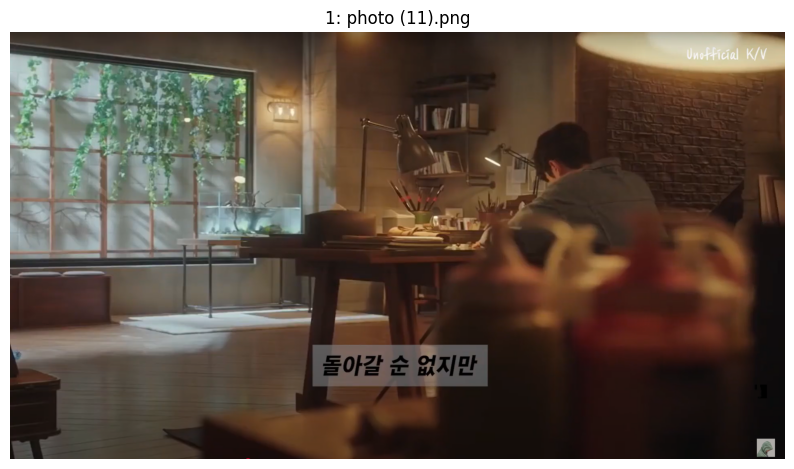

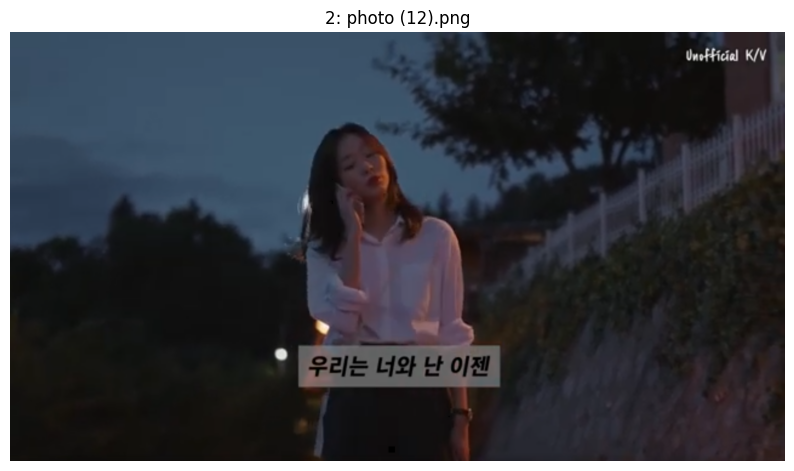

In [13]:
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import os

# sample_photos 폴더 내 모든 이미지 파일 경로 리스트로 가져오기
photo_folder = './sample_photos'
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
photo_list = [
    os.path.join(photo_folder, fname)
    for fname in os.listdir(photo_folder)
    if fname.lower().endswith(image_extensions)
]

print(f"총 {len(photo_list)}개의 이미지 파일을 찾았습니다.")

# photo_list에 있는 이미지 하나씩 불러와서 모두 출력
for idx, img_path in enumerate(photo_list):
    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.title(f"{idx+1}: {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()

## Crop 영역 지정


===== 1/2 : photo (11).png =====


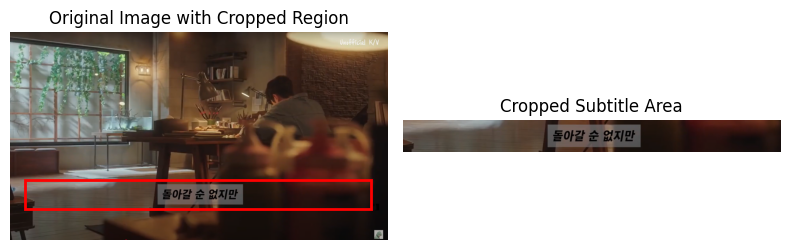


===== 2/2 : photo (12).png =====


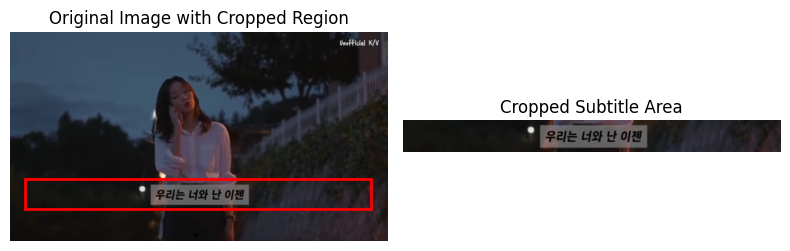

In [16]:
def process_image(img_path):
    # 1. 이미지 불러오기
    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # 2. Crop 영역 지정
    top = 1000
    bottom = 1200
    left = 100
    right = 2450
    crop_width = right - left
    crop_height = bottom - top
    cropped_image = image_rgb[top:bottom, left:right]

    # 3. 시각화 (원본+crop)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image_rgb)
    rect = patches.Rectangle((left, top), crop_width, crop_height,
                             linewidth=2, edgecolor='red', facecolor='none')
    ax1.add_patch(rect)
    ax1.set_title("Original Image with Cropped Region")
    ax1.axis('off')
    ax2.imshow(cropped_image)
    ax2.set_title("Cropped Subtitle Area")
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

    # 이후 자막 인식 등 필요한 추가 코드도 여기에 넣으면 됩니다.
    # 예시: return cropped_image
    return cropped_image

cropped_images = []  # 모든 crop 이미지를 저장할 리스트

for idx, img_path in enumerate(photo_list):
    print(f"\n===== {idx+1}/{len(photo_list)} : {os.path.basename(img_path)} =====")
    cropped_image = process_image(img_path)
    cropped_images.append(cropped_image)  # 리스트에 추가
    # 이후 cropped_image를 활용한 추가 처리(자막 인식 등)도 반복문 안에서 수행

## 자막 인식 - 1


===== Cropped Image 1/2 =====
Target Color (RGB): [4 0 0]


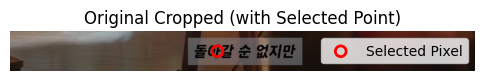

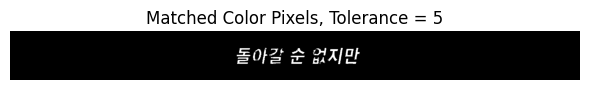

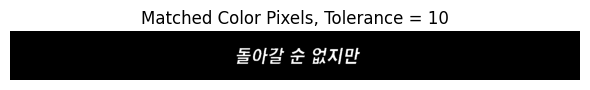

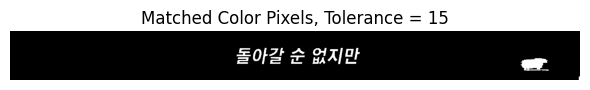

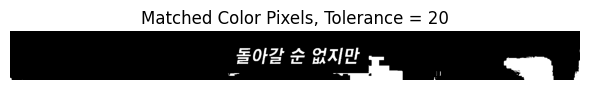

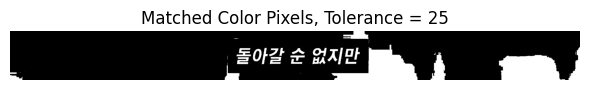

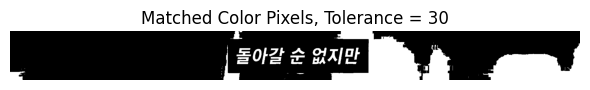

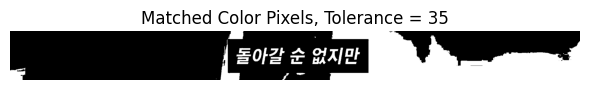

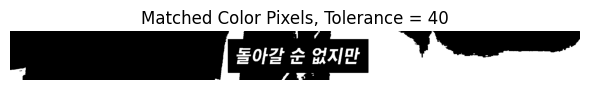

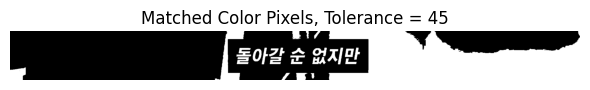

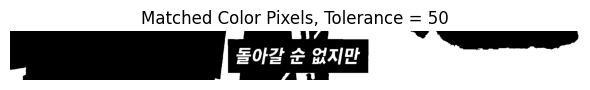


===== Cropped Image 2/2 =====
Target Color (RGB): [8 4 3]


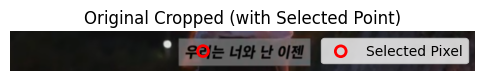

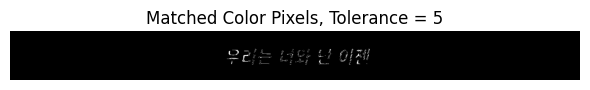

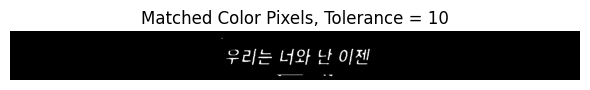

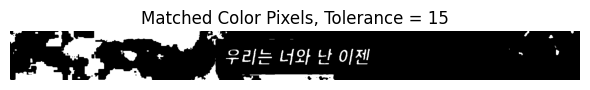

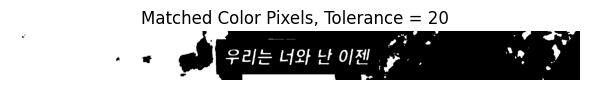

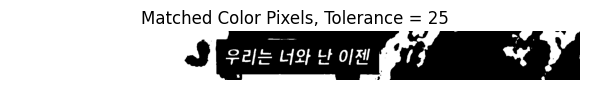

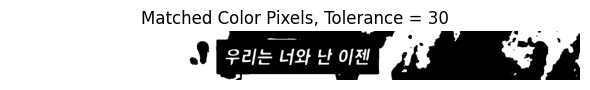

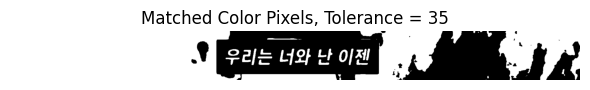

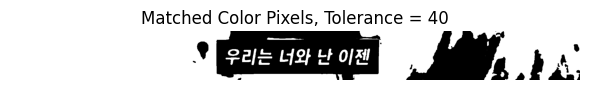

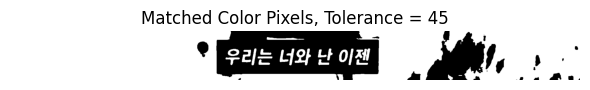

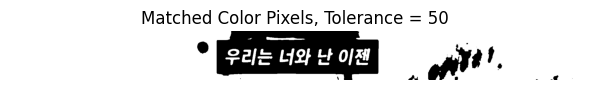

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def highlight_subtitle_area(cropped_image, y=100, x=1048, tolerances=range(5, 51, 5)):
    target_color = cropped_image[y, x].astype(int)  # <-- int로 변환
    print(f"Target Color (RGB): {target_color}")

    # 원본 크롭 이미지 + 점 표시
    plt.figure(figsize=(6, 5))
    plt.imshow(cropped_image)
    plt.scatter(x, y, s=60, facecolors='none', edgecolors='red', linewidths=2, marker='o', label='Selected Pixel')
    plt.title("Original Cropped (with Selected Point)")
    plt.axis('off')
    plt.legend(loc='upper right')

    highlighted_image_results = []
    for tolerance in tolerances:
        lower = np.array([max(0, c - tolerance) for c in target_color])
        upper = np.array([min(255, c + tolerance) for c in target_color])

        cropped_bgr = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)
        lower_bgr = np.array([lower[2], lower[1], lower[0]])
        upper_bgr = np.array([upper[2], upper[1], upper[0]])
        mask = cv2.inRange(cropped_bgr, lower_bgr, upper_bgr)

        highlighted_image = np.full_like(cropped_image, 0)
        highlighted_image[mask == 255] = [255, 255, 255]

        highlighted_image_results.append({
            "tolerance": tolerance,
            "highlighted_image": highlighted_image.copy(),
            "mask": mask.copy(),
            "white_pixel_count": np.sum(mask == 255)
        })

    # 시각화
    for result in highlighted_image_results:
        plt.figure(figsize=(6, 5))
        plt.imshow(result["highlighted_image"])
        plt.title(f"Matched Color Pixels, Tolerance = {result['tolerance']}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    return highlighted_image_results

target_pixel_list = [(100, 1048), (99, 975)]

# 모든 cropped image에 대해 반복 적용
for idx, cropped_image in enumerate(cropped_images):
    print(f"\n===== Cropped Image {idx+1}/{len(cropped_images)} =====")
    highlight_subtitle_area(cropped_image, target_pixel_list[idx][0], target_pixel_list[idx][1])

## 자막 인식 - 2

In [29]:
import cv2
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
import numpy as np

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def ocr_highlighted_images(highlighted_image_results):
    conf_thresholds = [0, 10, 50]
    psm_modes = {
        "psm6": '--oem 3 --psm 6 -l kor+eng',
        "psm8": '--oem 3 --psm 8 -l kor+eng',
        "psm10": '--oem 3 --psm 10 -l kor+eng'
    }

    for result in highlighted_image_results:
        highlighted_image = result["highlighted_image"]
        tolerance = result["tolerance"]

        gray = cv2.cvtColor(highlighted_image, cv2.COLOR_RGB2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 0.01)
        _, binary = cv2.threshold(blurred, 10, 255, cv2.THRESH_BINARY)
        dilated = cv2.dilate(binary, np.ones((2, 2), np.uint8), iterations=1)

        image_height, image_width = dilated.shape

        ocr_outputs = []

        for conf_threshold in conf_thresholds:
            for label, config in psm_modes.items():
                results = pytesseract.image_to_data(dilated, output_type=Output.DICT, config=config)
                vis_image = cv2.cvtColor(dilated, cv2.COLOR_GRAY2RGB)
                recognized_texts = []

                n_boxes = len(results['level'])
                for i in range(n_boxes):
                    text = results['text'][i].strip()
                    conf = int(results['conf'][i])
                    x = results['left'][i]
                    y = results['top'][i]
                    w = results['width'][i]
                    h = results['height'][i]

                    if (conf > conf_threshold and text != '' and
                        x > 0 and y > 0 and x + w < image_width and y + h < image_height):

                        roi = dilated[y:y+h, x:x+w]
                        white_rows = np.where(np.any(roi == 255, axis=1))[0]
                        if len(white_rows) == 0:
                            continue

                        y1, y2 = white_rows[0], white_rows[-1]
                        new_y = y + y1
                        new_h = y2 - y1 + 1

                        cv2.rectangle(vis_image, (x, new_y), (x + w, new_y + new_h), (255, 0, 0), 2)
                        cv2.putText(vis_image, text, (x, new_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 128, 0), 1)
                        recognized_texts.append((text, conf))

                ocr_outputs.append({
                    "psm": label,
                    "conf_threshold": conf_threshold,
                    "image": vis_image,
                    "texts": recognized_texts
                })

        for result in ocr_outputs:
            psm = result["psm"]
            conf_th = result["conf_threshold"]
            print(f"\n🔎 PSM: {psm}, Conf Threshold: {conf_th}, Tolerance = {tolerance}")
            for i, (text, conf) in enumerate(result["texts"]):
                print(f"{i}: '{text}' (conf: {conf})")

            plt.figure(figsize=(12, 8))
            plt.imshow(result["image"])
            plt.title(f"OCR Result: {psm}, Conf > {conf_th}, Tolerance = {tolerance}")
            plt.axis('off')
            plt.tight_layout()
            plt.show()

# 예시: 모든 cropped image에 대해 highlight_subtitle_area → ocr_highlighted_images 순차 적용
for idx, cropped_image in enumerate(cropped_images):
    print(f"\n===== Cropped Image {idx+1}/{len(cropped_images)} =====")
    # 좌표는 필요에 따라 조정
    highlighted_image_results = highlight_subtitle_area(cropped_image, y=100, x=1048)
    ocr_highlighted_images(highlighted_image_results)

ModuleNotFoundError: No module named 'pytesseract'

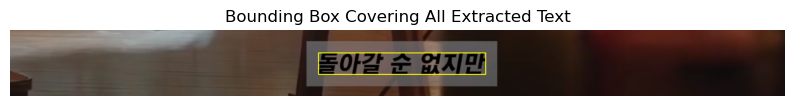

In [5]:
# mask == 255인 모든 좌표 추출
ys, xs = np.where(mask == 255)

# 해당 픽셀이 하나라도 존재할 경우
if len(xs) > 0 and len(ys) > 0:
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    # 사각형 좌표 계산
    box_x, box_y = x_min, y_min
    box_w, box_h = x_max - x_min, y_max - y_min

    # 원본 crop 이미지 복사 후 박스 그리기
    boxed_image = cropped_image.copy()
    cv2.rectangle(boxed_image, (box_x, box_y), (box_x + box_w, box_y + box_h), color=(255, 255, 0), thickness=2)  # 노란색

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(boxed_image)
    plt.title("Bounding Box Covering All Extracted Text")
    plt.axis('off')
    plt.show()
else:
    print("No matching pixels found in the mask.")


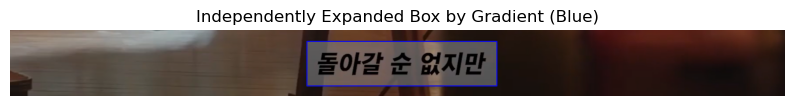

In [6]:
# Grayscale 이미지 준비
gray_crop = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)

# 초기 bounding box (1픽셀 여유)
ys, xs = np.where(mask == 255)
x_min, x_max = xs.min() - 1, xs.max() + 1
y_min, y_max = ys.min() - 1, ys.max() + 1
box_x, box_y = x_min, y_min
box_w = x_max - x_min
box_h = y_max - y_min

# Sobel 연산으로 gradient 계산 (x, y 방향)
sobel_x = cv2.Sobel(gray_crop, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray_crop, cv2.CV_64F, 0, 1, ksize=3)
gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

# 기준
max_expand = 40
gradient_threshold = 60

# 각 방향 확장 거리 초기화
expand_top = expand_bottom = expand_left = expand_right = 0

# 위쪽 확장
for i in range(1, max_expand):
    y = box_y - i
    if y < 0: break
    grad_line = gradient_magnitude[y, box_x:box_x + box_w]
    if np.mean(grad_line) >= gradient_threshold:
        expand_top = i
        break

# 아래쪽 확장
for i in range(1, max_expand):
    y = box_y + box_h + i
    if y >= gray_crop.shape[0]: break
    grad_line = gradient_magnitude[y, box_x:box_x + box_w]
    if np.mean(grad_line) >= gradient_threshold:
        expand_bottom = i
        break

# 왼쪽 확장
for i in range(1, max_expand):
    x = box_x - i
    if x < 0: break
    grad_line = gradient_magnitude[box_y:box_y + box_h, x]
    if np.mean(grad_line) >= gradient_threshold:
        expand_left = i
        break

# 오른쪽 확장
for i in range(1, max_expand):
    x = box_x + box_w + i
    if x >= gray_crop.shape[1]: break
    grad_line = gradient_magnitude[box_y:box_y + box_h, x]
    if np.mean(grad_line) >= gradient_threshold:
        expand_right = i
        break

# 최종 좌표 계산
ex1 = max(0, box_x - expand_left)
ey1 = max(0, box_y - expand_top)
ex2 = min(gray_crop.shape[1], box_x + box_w + expand_right)
ey2 = min(gray_crop.shape[0], box_y + box_h + expand_bottom)

# 시각화
final_image = cropped_image.copy()
cv2.rectangle(final_image, (ex1, ey1), (ex2, ey2), color=(0, 0, 255), thickness=2)

plt.figure(figsize=(10, 5))
plt.imshow(final_image)
plt.title("Independently Expanded Box by Gradient (Blue)")
plt.axis('off')
plt.show()
